# Task

### Pre-defined code

In [1]:
# # Mounting google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

In [2]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/cv-learnings/B/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 6/6 [00:00<00:00, 293.85it/s]


In [3]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

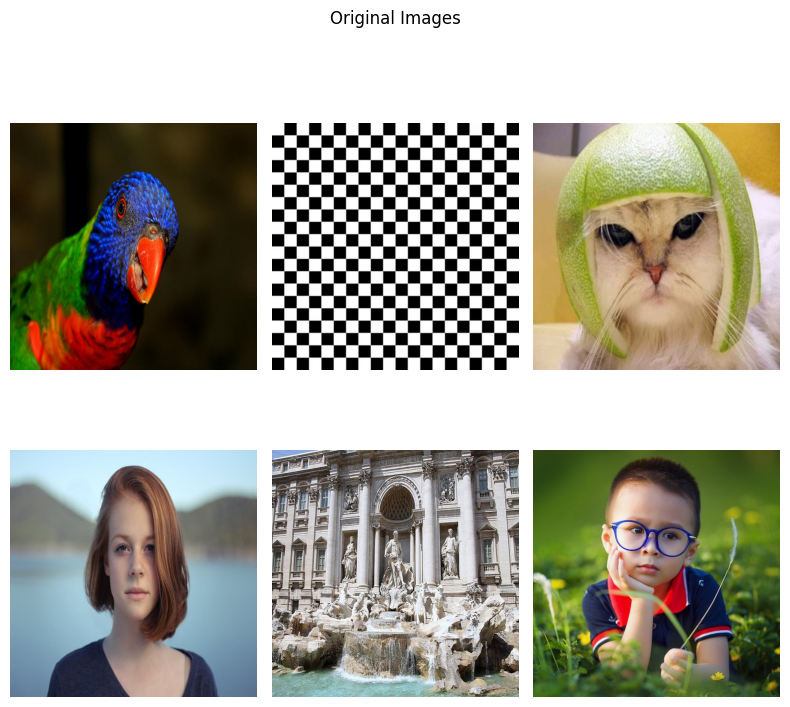

In [4]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [5]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [27]:
# Function to create a Gaussian kernel
def gaussian_kernel(size=5, sigma=1):
    """
    Creates a 2D Gaussian kernel.
    size: Kernel size (must be odd)
    sigma: Standard deviation for Gaussian
    """
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

# Function to convolve an image with a kernel
def convolve(image, kernel):
    """
    Convolves a given image with a specified kernel (2D convolution).
    image: Input image
    kernel: Gaussian kernel
    """
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
    
    # Output image placeholder
    output = np.zeros_like(image)
    
    # Iterate over the image
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):  # For each channel
                # Extract the region of interest and perform element-wise multiplication
                region = padded_image[y:y + kernel_size, x:x + kernel_size, c]
                output[y, x, c] = np.sum(region * kernel)
    
    return output


# Function to downsample the image
def downsample(image):
    """
    Downsamples the image by taking every second pixel (factor of 2).
    """
    return image[::2, ::2]


# def gaussian_pyramid(image, levels):
#     pyramid = [image]
#     for i in range(levels - 1):
#         # Apply Gaussian blur and downsample by a factor of 2

#         # Write code here

        

#         image = pad_image_to_divisible(image, pyramid[0].shape[0])
#         pyramid.append(image)

#     return np.array(pyramid)


def gaussian_pyramid(image, levels):
    pyramid = [image]  # First level is the original image
    
    kernel = gaussian_kernel(5, sigma=1)  # Create a 5x5 Gaussian kernel
    
    for i in range(levels - 1):
        # Apply Gaussian blur (convolution) and downsample
        blurred = convolve(image, kernel)
        downsampled = downsample(blurred)
        downsampled = pad_image_to_divisible(downsampled, 2)  # Pad to keep dimensions divisible by 2 if needed
        pyramid.append(downsampled)  # Add the downsampled image to the pyramid
        image = downsampled  # Update the image for the next level
    
    return pyramid  

# def opencv_resize(inp_image, levels):
#     pyramid = []
#     h, w    = inp_image.shape[:2]
#     for i in range(levels):
#         # Apply Gaussian blur and downsample by a factor of 2
#         # Write code here
#         image = cv2.resize(inp_image, (h//2**i, w//2**i))

#         image = pad_image_to_divisible(image, min(h, w))
#         pyramid.append(image)

#     return np.array(pyramid)



def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        # Apply Gaussian blur and downsample by a factor of 2
        # Write code here
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)  # 5x5 kernel, sigma=0 (auto)
        downsampled_image = cv2.resize(blurred_image, (blurred_image.shape[1] // 2, blurred_image.shape[0] // 2))
        pyramid.append(downsampled_image)
        image = cv2.resize(inp_image, (h//2*i, w//2*i))

        image = pad_image_to_divisible(downsampled_image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

In [ ]:
# Example usage of the function
for idx, image in enumerate(gt_images):
    # Generate pyramid of images using OpenCV-based Gaussian pyramid
    s_image_opencv_resize = opencv_resize(image, levels=4)

    # Access and print pyramid levels
    for i, img in enumerate(s_image_opencv_resize):
        print(f"OpenCV Level {i} shape: {img.shape}")

UnboundLocalError: cannot access local variable 'image' where it is not associated with a value

In [21]:
# Example usage:
for idx, image in enumerate(gt_images):
    print(f"\nProcessing image {idx+1}/{len(gt_images)}")

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)




    # Access and process pyramid levels (as a list)
    for i, (gauss_img,open_img) in enumerate(zip(s_image_pyramids,s_image_opecv_resize)):
        print(f"Custom Level {i} shape: {gauss_img.shape}")
        print(f"OpenCV Level {i} shape: {open_img.shape}")


Processing image 1/6
Custom Level 0 shape: (512, 512, 3)
OpenCV Level 0 shape: (512, 512, 3)
Custom Level 1 shape: (256, 256, 3)
OpenCV Level 1 shape: (512, 512, 3)
Custom Level 2 shape: (128, 128, 3)
OpenCV Level 2 shape: (512, 512, 3)
Custom Level 3 shape: (64, 64, 3)
OpenCV Level 3 shape: (512, 512, 3)

Processing image 2/6
Custom Level 0 shape: (512, 512, 3)
OpenCV Level 0 shape: (512, 512, 3)
Custom Level 1 shape: (256, 256, 3)
OpenCV Level 1 shape: (512, 512, 3)
Custom Level 2 shape: (128, 128, 3)
OpenCV Level 2 shape: (512, 512, 3)
Custom Level 3 shape: (64, 64, 3)
OpenCV Level 3 shape: (512, 512, 3)

Processing image 3/6
Custom Level 0 shape: (512, 512, 3)
OpenCV Level 0 shape: (512, 512, 3)
Custom Level 1 shape: (256, 256, 3)
OpenCV Level 1 shape: (512, 512, 3)
Custom Level 2 shape: (128, 128, 3)
OpenCV Level 2 shape: (512, 512, 3)
Custom Level 3 shape: (64, 64, 3)
OpenCV Level 3 shape: (512, 512, 3)

Processing image 4/6
Custom Level 0 shape: (512, 512, 3)
OpenCV Level 0 sha

In [11]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:658: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [6]:
def laplacian_pyramid_blend_images(image_a, image_b):
    A = cv2.resize(image_a, (512, 512))
    B = cv2.resize(image_b, (512, 512))

    # Generate Gaussian pyramid for A
    G = A.copy()
    gpA = [G]
    for i in range(6):
        G = cv2.pyrDown(G)
        gpA.append(G)

    # Generate Gaussian pyramid for B
    G = B.copy()
    gpB = [G]
    for i in range(6):
        G = cv2.pyrDown(G)
        gpB.append(G)

    # Generate Laplacian pyramid for A
    lpA = [gpA[5]]
    for i in range(5, 0, -1):
        GE = cv2.pyrUp(gpA[i])
        L = cv2.subtract(gpA[i-1], GE)
        lpA.append(L)

    # Generate Laplacian pyramid for B
    lpB = [gpB[5]]
    for i in range(5, 0, -1):
        GE = cv2.pyrUp(gpB[i])
        L = cv2.subtract(gpB[i-1], GE)
        lpB.append(L)

    # Now add left and right halves of images in each level
    LS = []
    for la, lb in zip(lpA, lpB):
        rows, cols, dpt = la.shape
        ls = np.hstack((la[:, 0:cols // 2], lb[:, cols // 2:]))
        LS.append(ls)

    # Now reconstruct the image from the blended pyramid
    ls_ = LS[0]
    for i in range(1, 6):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, LS[i])

    blended_image = ls_

    # Show the real combination of half images for comparison
    real = np.hstack((A[:, :cols // 2], B[:, cols // 2:]))

    # Return the blended image
    return blended_image if blended_image is not None else image_a

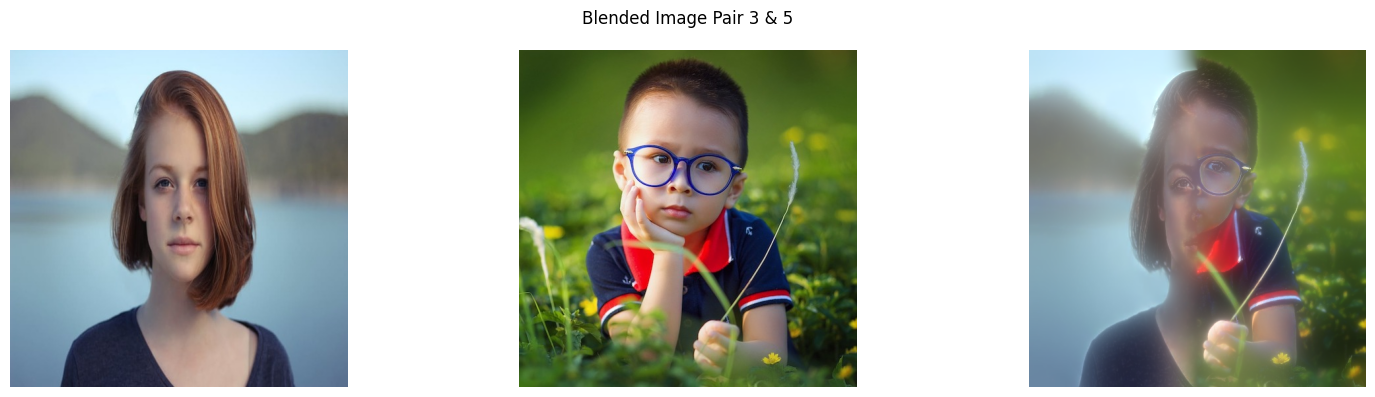

In [7]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

In [70]:
def convolution(image, kernel):
    # Implementing convolution using padding and sliding window
    image_padded = np.pad(image, ((kernel.shape[0]//2, kernel.shape[0]//2), 
                                  (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant')
    result = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i, j] = np.sum(kernel * image_padded[i:i+kernel.shape[0], j:j+kernel.shape[1]])
    
    return result

def detect_harris_corner(image, k=0.04, threshold=1e-3):
    # Step 1: Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    gray = gray.astype(np.float32)
    
    # Step 2: Compute gradients using Sobel operator
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # Sobel kernel for x-derivative
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # Sobel kernel for y-derivative
    
    Ix = convolution(gray, sobel_x)
    Iy = convolution(gray, sobel_y)
    
    # Step 3: Compute products of derivatives
    Ixx = Ix * Ix
    Ixy = Ix * Iy
    Iyy = Iy * Iy
    
    # Step 4: Apply Gaussian smoothing
    gauss_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16.0
    Sxx = convolution(Ixx, gauss_kernel)
    Sxy = convolution(Ixy, gauss_kernel)
    Syy = convolution(Iyy, gauss_kernel)
    
    # Step 5: Compute the Harris response
    det_M = Sxx * Syy - Sxy * Sxy
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)
    
    # Step 6: Thresholding and corner detection
    corner_image = np.zeros_like(R)
    corner_image[R > threshold * R.max()] = 255


    # Step 7: Plot corners on the original RGB image
    corner_points = np.argwhere(corner_image == 255)
    
    # Copy original image to mark corners in red
    rgb_image_with_corners = image.copy()
    
    for point in corner_points:
        x, y = point[0], point[1]
        cv2.circle(rgb_image_with_corners, (y, x), 1, (0, 0, 255), -1)  # Draw red circle at the corner
    
    return rgb_image_with_corners


def detect_hessian_corner(image, threshold=1e-3):
    # Step 1: Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    gray = gray.astype(np.float32)

    # Step 2: Compute second-order derivatives using Sobel operator and OpenCV's filter2D
    sobel_xx = np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]])  # 2nd order derivative in x
    sobel_yy = np.array([[1, 2, 1], [-2, -4, -2], [1, 2, 1]])  # 2nd order derivative in y
    sobel_xy = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])  # derivative in both x and y

    Ixx = cv2.filter2D(gray, -1, sobel_xx)
    Iyy = cv2.filter2D(gray, -1, sobel_yy)
    Ixy = cv2.filter2D(gray, -1, sobel_xy)

    # Step 3: Compute Hessian determinant
    det_H = Ixx * Iyy - Ixy * Ixy

    # Step 4: Thresholding to identify corners
    corner_image = np.zeros_like(det_H)
    corner_image[det_H > threshold * det_H.max()] = 255


    # Step 5: Plot corners on the original RGB image
    corner_points = np.argwhere(corner_image == 255)
    
    # Copy original image to mark corners in red
    rgb_image_with_corners = image.copy()
    
    for point in corner_points:
        x, y = point[0], point[1]
        cv2.circle(rgb_image_with_corners, (y, x), 1, (0, 0, 255), -1)  # Draw red circle at the corner
    
    return rgb_image_with_corners




# def detect_harris_corner(image):
#     corner_image  = None

#     # Write your code here

#     if corner_image == None:
#         return image

#     return corner_image

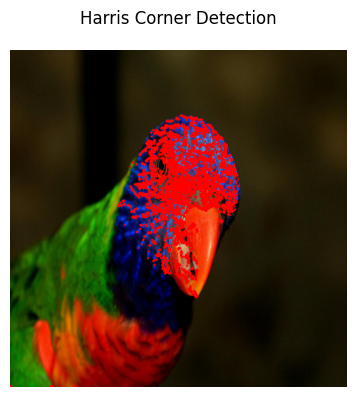

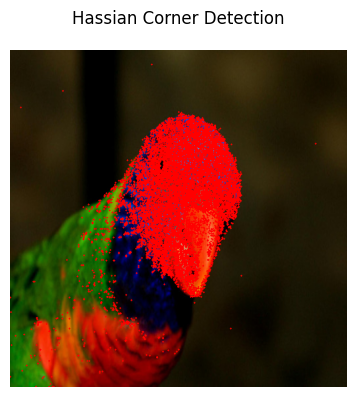

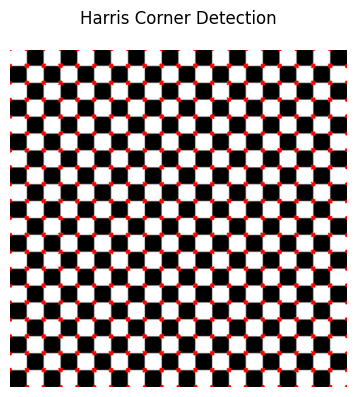

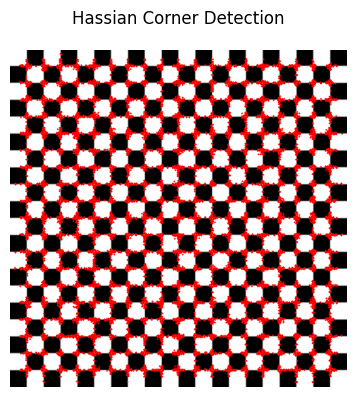

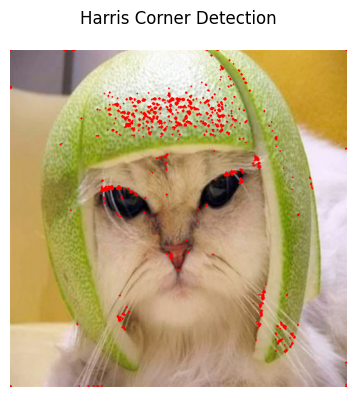

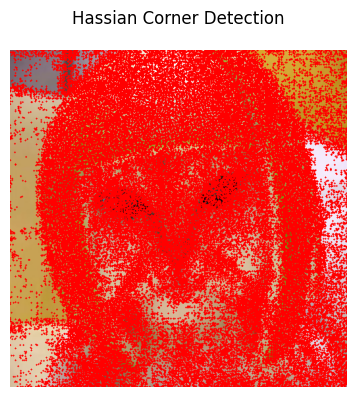

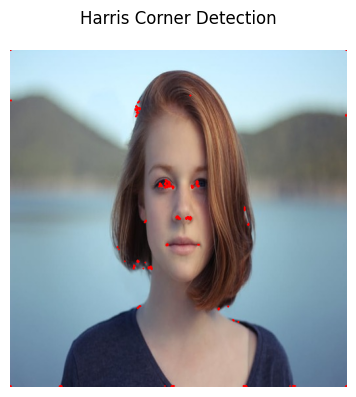

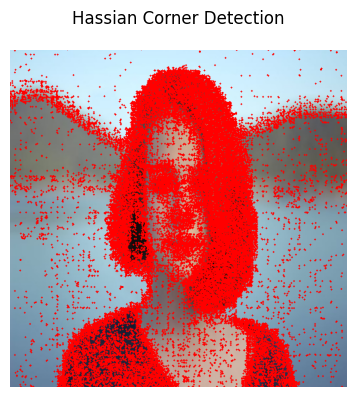

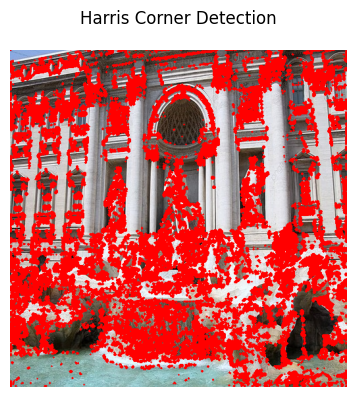

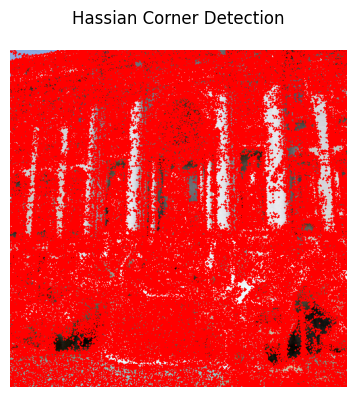

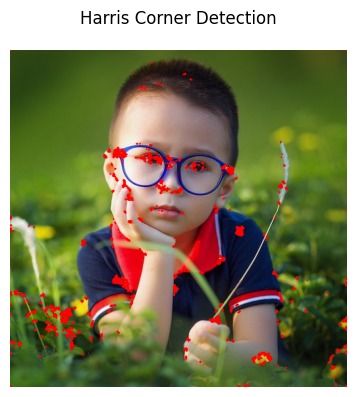

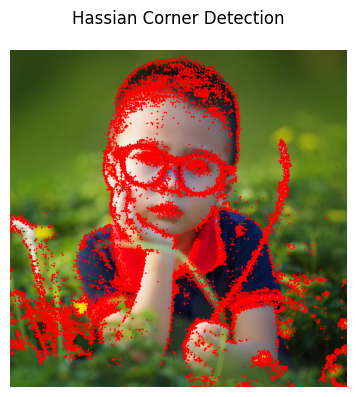

In [71]:
for image in gt_images:
    corner_image_1 = detect_harris_corner(image)
    corner_image_2=detect_hessian_corner(image)

    show_image_grid(corner_image_1, 1, 1, 'Harris Corner Detection', figsize=16)
    show_image_grid(corner_image_2,1,1,'Hassian Corner Detection', figsize=16)